Stopping early at generation 45 due to no improvement
Best Parking Allocation: [52, 48, 67, 81, 49, 37, 68, 5, 36, 20, 82, 55, 75, 66, 44, 84, 15, 50, 74, 58, 28, 51, 72, 13, 56, 27, 97, 70, 18, 1, 31, 54, 40, 98, 32, 6, 47, 65, 88, 38, 76, 8, 77, 41, 43, 26, 85, 45, 64, 57]
Total Walking Distance: 193.85067476830005


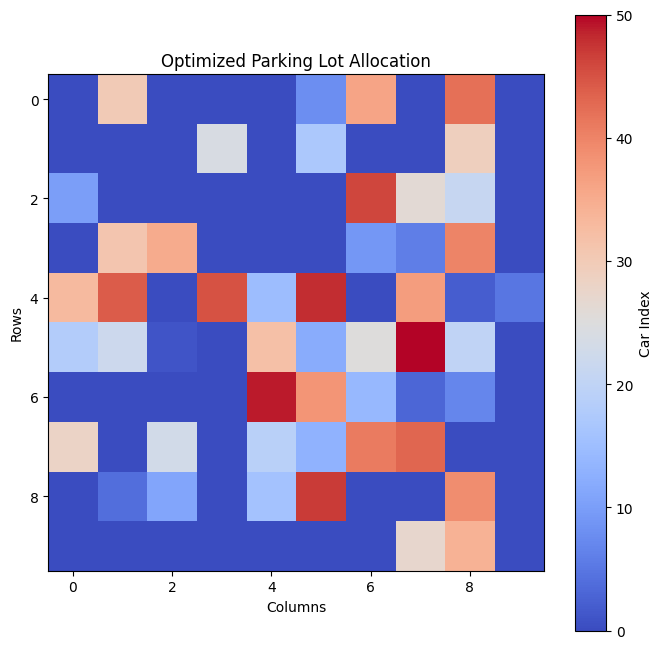

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parking lot details
GRID_SIZE = 10
PARKING_SPOTS = [(i, j) for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
ENTRANCE = (5, 5)
CHARGING_STATIONS = [(1, 1), (2, 8), (5, 5), (7, 3), (9, 9)]

NUM_CARS = 50
NUM_EV = 10
NUM_DISABLED = 5
NUM_REGULAR = NUM_CARS - (NUM_EV + NUM_DISABLED)

POPULATION_SIZE = 100
GENERATIONS = 100
TOURNAMENT_SIZE = 5
MUTATION_RATE = 0.1
NO_IMPROVEMENT_LIMIT = 20

# Convert row and column to single index for easier chromosome representation
def to_index(position):
    return position[0] * GRID_SIZE + position[1]

def from_index(index):
    return (index // GRID_SIZE, index % GRID_SIZE)

# Fitness Function
def euclidean_distance(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def fitness(chromosome):
    total_distance = 0
    penalty = 0

    # Convert index representation to coordinates
    assigned_positions = [from_index(idx) for idx in chromosome]

    # Calculate total walking distance
    for i, position in enumerate(assigned_positions):
        if i < NUM_EV:  # EV Cars
            nearest_station = min(CHARGING_STATIONS, key=lambda s: euclidean_distance(position, s))
             # Penalize distance from station
            penalty += euclidean_distance(position, nearest_station)
        # Disabled Cars
        elif i < NUM_EV + NUM_DISABLED:
            # Penalize distance from entrance
            penalty += euclidean_distance(position, ENTRANCE)

        total_distance += euclidean_distance(position, ENTRANCE)

    return total_distance + penalty  # Lower is better

# Initialization
def initialize_population():
    population = []
    for _ in range(POPULATION_SIZE):
        assigned_spots = random.sample(range(100), NUM_CARS)  # Unique spots for cars
        population.append(assigned_spots)
    return population

# Tournament Selection
def tournament_selection(population, scores):
    selected = random.sample(range(len(population)), TOURNAMENT_SIZE)
    best = min(selected, key=lambda idx: scores[idx])
    return population[best]

# Uniform Crossover
def uniform_crossover(parent1, parent2):
    child = parent1[:]
    for i in range(NUM_CARS):
        if random.random() < 0.5:
            child[i] = parent2[i]  # Swap genes with 50% probability
    return list(set(child)) if len(set(child)) == NUM_CARS else parent1  # Ensure uniqueness

# Swap Mutation
def swap_mutation(chromosome):
    if random.random() < MUTATION_RATE:
        idx1, idx2 = random.sample(range(NUM_CARS), 2)
        chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome

# Genetic Algorithm
def genetic_algorithm():
    population = initialize_population()
    best_solution = None
    best_score = float('inf')
    no_improvement = 0

    for gen in range(GENERATIONS):
        scores = [fitness(chromo) for chromo in population]
        best_idx = np.argmin(scores)

        if scores[best_idx] < best_score:
            best_score = scores[best_idx]
            best_solution = population[best_idx]
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= NO_IMPROVEMENT_LIMIT:
            print(f"Stopping early at generation {gen} due to no improvement")
            break

        # Create new generation
        new_population = []
        for _ in range(POPULATION_SIZE // 2):
            p1 = tournament_selection(population, scores)
            p2 = tournament_selection(population, scores)
            child1, child2 = uniform_crossover(p1, p2), uniform_crossover(p2, p1)
            new_population.extend([swap_mutation(child1), swap_mutation(child2)])

        population = new_population

    return best_solution, best_score

# Visualization
def visualize_solution(best_solution):
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    for i, index in enumerate(best_solution):
        row, col = from_index(index)
        grid[row, col] = i + 1  # Assign car index

    plt.figure(figsize=(8, 8))
    plt.imshow(grid, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Car Index")
    plt.title("Optimized Parking Lot Allocation")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

# Run the GA
best_solution, best_score = genetic_algorithm()
print(f"Best Parking Allocation: {best_solution}")
print(f"Total Walking Distance: {best_score}")
visualize_solution(best_solution)


In [2]:
import random

# Define strategies
strategies = {
    "S1": {"return": 0.5, "risk": 1, "drawdown": -1},
    "S2": {"return": 1.2, "risk": 2, "drawdown": -2.5},
    "S3": {"return": 2.5, "risk": 3, "drawdown": -5},
    "S4": {"return": 5, "risk": 4, "drawdown": -10},
    "S5": {"return": 10, "risk": 5, "drawdown": -15},
}
strategy_list = list(strategies.keys())

# Generate random chromosome
def random_chromosome():
    chromosome = [random.choice(strategy_list)]
    for _ in range(29):
        choices = [s for s in strategy_list if s != chromosome[-1]]
        chromosome.append(random.choice(choices))
    return chromosome

# Fitness function
def fitness(chromosome):
    total_return, total_drawdown, penalty = 0, 0, 0
    for i, strategy in enumerate(chromosome):
        total_return += strategies[strategy]["return"]
        total_drawdown += strategies[strategy]["drawdown"]
        if i > 0 and chromosome[i] == chromosome[i-1]:
            penalty += 5
    if any(strategies[s]["drawdown"] < -15 for s in chromosome):
        penalty += 10
    if total_drawdown < -30:
        penalty += 20
    return total_return - penalty

# Tournament selection
def select(population):
    return max(random.sample(population, 5), key=fitness)

# Crossover
def crossover(parent1, parent2):
    point = random.randint(1, 28)
    child = parent1[:point] + parent2[point:]
    return fix_chromosome(child)

# Mutation
def mutate(chromosome):
    if random.random() < 0.05:
        idx = random.randint(0, 29)
        choices = [s for s in strategy_list if s != chromosome[idx]]
        chromosome[idx] = random.choice(choices)
    return chromosome

# Ensure valid chromosome
def fix_chromosome(chromosome):
    for i in range(1, 30):
        if chromosome[i] == chromosome[i-1]:
            choices = [s for s in strategy_list if s != chromosome[i]]
            chromosome[i] = random.choice(choices)
    return chromosome

# Genetic Algorithm
def genetic_algorithm():
    population = [random_chromosome() for _ in range(100)]
    for _ in range(100):
        new_population = []
        for _ in range(50):
            parent1, parent2 = select(population), select(population)
            child = crossover(parent1, parent2)
            new_population.extend([mutate(child), mutate(parent1)])
        population = new_population
    best_strategy = max(population, key=fitness)
    return best_strategy, fitness(best_strategy)


best_sequence, best_profit = genetic_algorithm()
print("Best Trading Sequence:", best_sequence)
print("Total Profit:", best_profit)


Best Trading Sequence: ['S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5']
Total Profit: 205


In [3]:
import random

# Grid and parameters
ROWS, COLS = 3, 50
BLOCKED_RATIO = 0.3  # 30% of the grid is mafia-controlled
POP_SIZE = 10  # Population size
GENS = 100  # Number of generations
MOVES_LIMIT = 70  # Max allowed moves
MUTATION_RATE = 0.1  # Mutation rate

# Movement actions and constraints
ACTIONS = ['F', 'B', 'J', 'D', 'SJ', 'Dash']
MOVES = {'F': (0, 1), 'B': (0, -1), 'J': (-1, 0), 'D': (1, 0), 'SJ': (-2, 0), 'Dash': (0, 2)}

def create_grid():
    grid = [[0 for _ in range(COLS)] for _ in range(ROWS)]
    blocked_cells = random.sample(range(ROWS * COLS), int(BLOCKED_RATIO * ROWS * COLS))
    for cell in blocked_cells:
        r, c = divmod(cell, COLS)
        grid[r][c] = 1  # Mark as mafia-controlled
    grid[2][0], grid[0][COLS - 1] = 0, 0  # Ensure start and exit are open
    return grid

def random_chromosome():
    return [random.choice(ACTIONS) for _ in range(MOVES_LIMIT)]

def fitness(chromosome, grid):
    r, c, moves, score = 2, 0, 0, 0
    for move in chromosome:
        if moves >= MOVES_LIMIT:
            break
        dr, dc = MOVES[move]
        new_r, new_c = r + dr, c + dc
        if 0 <= new_r < ROWS and 0 <= new_c < COLS and grid[new_r][new_c] == 0:
            r, c = new_r, new_c
            score += 10  # Reward movement
            if (r, c) == (0, COLS - 1):
                return 1000 - moves  # Huge reward for reaching exit early
        else:
            score -= 5  # Penalize invalid moves
        moves += 1
    return score

def selection(pop, grid):
    return sorted(pop, key=lambda x: fitness(x, grid), reverse=True)[:2]

def crossover(parent1, parent2):
    point = random.randint(1, MOVES_LIMIT - 1)
    return parent1[:point] + parent2[point:]

def mutate(chromosome):
    if random.random() < MUTATION_RATE:
        idx = random.randint(0, MOVES_LIMIT - 1)
        chromosome[idx] = random.choice(ACTIONS)
    return chromosome

def genetic_algorithm():
    grid = create_grid()
    population = [random_chromosome() for _ in range(POP_SIZE)]

    for _ in range(GENS):
        population = sorted(population, key=lambda x: fitness(x, grid), reverse=True)
        new_pop = selection(population, grid)
        while len(new_pop) < POP_SIZE:
            p1, p2 = random.sample(new_pop, 2)
            child = crossover(p1, p2)
            new_pop.append(mutate(child))
        population = new_pop

    best = max(population, key=lambda x: fitness(x, grid))
    return best, fitness(best, grid)

best_path, score = genetic_algorithm()
print("Best Path:", best_path)
print("Fitness Score:", score)

Best Path: ['B', 'F', 'F', 'Dash', 'SJ', 'F', 'D', 'D', 'F', 'SJ', 'D', 'J', 'F', 'Dash', 'Dash', 'B', 'SJ', 'F', 'B', 'SJ', 'Dash', 'D', 'B', 'F', 'SJ', 'D', 'B', 'SJ', 'Dash', 'B', 'B', 'Dash', 'D', 'B', 'D', 'F', 'J', 'B', 'J', 'D', 'F', 'B', 'D', 'J', 'D', 'F', 'B', 'Dash', 'B', 'Dash', 'B', 'Dash', 'SJ', 'B', 'F', 'B', 'D', 'D', 'J', 'B', 'B', 'J', 'Dash', 'Dash', 'Dash', 'Dash', 'B', 'J', 'B', 'SJ']
Fitness Score: 520


In [4]:
import random

# Grid and parameters
ROWS, COLS = 3, 50
BLOCKED_RATIO = 0.3  # 30% of the grid is mafia-controlled
POP_SIZE = 10  # Population size
GENS = 100  # Number of generations
MOVES_LIMIT = 70  # Max allowed moves
MUTATION_RATE = 0.1  # Mutation rate

# Movement actions and constraints
ACTIONS = ['F', 'B', 'J', 'D', 'SJ', 'Dash']
MOVES = {'F': (0, 1), 'B': (0, -1), 'J': (-1, 0), 'D': (1, 0), 'SJ': (-2, 0), 'Dash': (0, 2)}

def create_grid():
    grid = [[0 for _ in range(COLS)] for _ in range(ROWS)]
    blocked_cells = random.sample(range(ROWS * COLS), int(BLOCKED_RATIO * ROWS * COLS))
    for cell in blocked_cells:
        r, c = divmod(cell, COLS)
        grid[r][c] = 1  # Mark as mafia-controlled
    grid[2][0], grid[0][COLS - 1] = 0, 0  # Ensure start and exit are open
    return grid

def random_chromosome():
    return [random.choice(ACTIONS) for _ in range(MOVES_LIMIT)]

def fitness(chromosome, grid):
    r, c, moves, score = 2, 0, 0, 0
    for move in chromosome:
        if moves >= MOVES_LIMIT:
            break
        dr, dc = MOVES[move]
        new_r, new_c = r + dr, c + dc
        if 0 <= new_r < ROWS and 0 <= new_c < COLS and grid[new_r][new_c] == 0:
            r, c = new_r, new_c
            score += 10  # Reward movement
            if (r, c) == (0, COLS - 1):
                return 1000 - moves  # Huge reward for reaching exit early
        else:
            score -= 5  # Penalize invalid moves
        moves += 1
    return score

def selection(pop, grid):
    return sorted(pop, key=lambda x: fitness(x, grid), reverse=True)[:2]

def crossover(parent1, parent2):
    point = random.randint(1, MOVES_LIMIT - 1)
    return parent1[:point] + parent2[point:]

def mutate(chromosome):
    if random.random() < MUTATION_RATE:
        idx = random.randint(0, MOVES_LIMIT - 1)
        chromosome[idx] = random.choice(ACTIONS)
    return chromosome

def genetic_algorithm():
    grid = create_grid()
    population = [random_chromosome() for _ in range(POP_SIZE)]

    for _ in range(GENS):
        population = sorted(population, key=lambda x: fitness(x, grid), reverse=True)
        new_pop = selection(population, grid)
        while len(new_pop) < POP_SIZE:
            p1, p2 = random.sample(new_pop, 2)
            child = crossover(p1, p2)
            new_pop.append(mutate(child))
        population = new_pop

    best = max(population, key=lambda x: fitness(x, grid))
    return best, fitness(best, grid)

best_path, score = genetic_algorithm()
print("Best Path:", best_path)
print("Fitness Score:", score)


Best Path: ['D', 'J', 'SJ', 'J', 'Dash', 'F', 'D', 'J', 'Dash', 'SJ', 'J', 'Dash', 'F', 'F', 'F', 'D', 'B', 'Dash', 'F', 'D', 'J', 'J', 'B', 'J', 'J', 'B', 'B', 'D', 'J', 'B', 'F', 'F', 'SJ', 'D', 'F', 'F', 'D', 'Dash', 'F', 'D', 'J', 'F', 'Dash', 'B', 'D', 'B', 'Dash', 'SJ', 'SJ', 'J', 'F', 'B', 'D', 'D', 'F', 'SJ', 'D', 'F', 'SJ', 'F', 'J', 'F', 'D', 'J', 'D', 'J', 'F', 'Dash', 'D', 'Dash']
Fitness Score: 415
